In [1]:
import scanpy as sc
import os
import anndata as ad
# Python packages
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import median_abs_deviation
from statsmodels import robust
import warnings
warnings.filterwarnings("ignore")
from adjustText import adjust_text
pd.set_option('display.max_columns', None)
import scanpy.external as sce
import sctk

/home/icb/yuting.wang/tools/miniconda3/envs/interoperability/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from skdim.id import MLE
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

In [3]:
#check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
Device count: 1
Device name: NVIDIA A100-PCIE-40GB MIG 3g.20gb


In [4]:
label_key = "scanvi_labels" #use transferred label from HLCA v1
batch_key = "sample_ID"
dataset_key= "study_name"
condition_key="condition"

library_key = "library_preparation_batch"

# Import the data

In [5]:
combined_palette = {
    'Yildirim_unpubl': '#D5006D',  # Dark Pink
    'Shaykhiev_publ': '#FFB6C1',  # Light Pink
    'Schiller_unpubl': '#800080',  # Purple
    'Nawijn_unpubl': '#0000FF',  # Standard Blue
    'lungMAP': '#1E90FF',  # Dodger Blue
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl': '#4682B4',  # Steel Blue
    'Niklason_Kaminski_publ': '#87CEEB'  # Sky Blue
}

Import integrated object from scvi and bbknn:

- library_key as integration key

In [6]:
adata_scvi = sc.read_h5ad('./data/adata_scvi_library.5had')

In [7]:
adata_bbknn = sc.read_h5ad('./data/adata_bbknn.5had')

In [8]:
adata_scvi

AnnData object with n_obs × n_vars = 773131 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

In [9]:
adata_bbknn

AnnData object with n_obs × n_vars = 773131 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

# Clustering

In [10]:
def clustering(adata, n_neighbors=10, leiden_resolution=0.5):
    """
    This function performs clustering on an AnnData object using the Leiden algorithm.

    Parameters:
    - adata: AnnData object with precomputed UMAP.
    - n_neighbors: int, number of neighbors for the neighbor graph construction.
    - leiden_resolution: float, resolution parameter for Leiden clustering.

    Returns:
    - None. Adds clustering labels to `adata.obs`.
    """
    # Perform neighbors and Leiden clustering
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)
    sc.tl.leiden(adata, resolution=leiden_resolution, key_added="leiden_res")

In [11]:
clustering(adata_scvi)

In [12]:
clustering(adata_bbknn)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


## Plot the clustering result

In [13]:
def generate_color_palette(categories):
    """
    Generate a consistent color palette for given categories.
    Specific colors for 'COPD' and 'Normal'.

    Parameters:
    - categories: list of unique categories.

    Returns:
    - A list of colors ordered to match the categories.
    """
    # Define specific colors for COPD and Normal
    color_mapping = {
        'COPD': 'red',
        'Normal': 'blue'
    }
    
    # Use a consistent color for any additional categories not specified
    remaining_categories = [cat for cat in categories if cat not in color_mapping]
    palette = sns.color_palette("husl", len(remaining_categories))  # Generate additional colors
    
    # Combine specific and generated colors, ensuring the order matches 'categories'
    color_list = [color_mapping.get(cat, palette.pop(0)) for cat in categories]
    
    return color_list

def plot_clustering_with_colors(adata, label_key, condition_key="condition"):
    """
    This function generates UMAP plots for Leiden clusters and specified keys with a consistent color palette.

    Parameters:
    - adata: AnnData object with clustering results.
    - label_key: str, name of the column in `adata.obs` representing cell types or labels.
    - condition_key: str, name of the column in `adata.obs` representing conditions (e.g., 'COPD', 'Normal').

    Returns:
    - None. Displays UMAP plots.
    """
    # Generate consistent color palettes for each key
    leiden_res_colors = generate_color_palette(adata.obs['leiden_res'].cat.categories)
    label_key_colors = generate_color_palette(adata.obs[label_key].cat.categories)
    condition_key_colors = generate_color_palette(adata.obs[condition_key].cat.categories)

    # Plot UMAP for Leiden clusters
    plt.figure(figsize=(8, 6))
    sc.pl.umap(adata, color='leiden_res', palette=leiden_res_colors,
               legend_loc='on data', title='Clusters in Integrated Data', legend_fontsize=8, show=False)

    # Plot UMAP for label key (e.g., cell type)
    sc.pl.umap(adata, color=label_key, palette=label_key_colors, 
               legend_loc='right margin', title=f'{label_key} in Integrated Data', legend_fontsize=8, show=False)

    # Plot UMAP for condition key (e.g., disease condition)
    sc.pl.umap(adata, color=condition_key, palette=condition_key_colors, 
               legend_loc='right margin', title=f'{condition_key} in Integrated Data', legend_fontsize=8, show=False)

    # Show all the plots
    plt.show()

<Figure size 800x600 with 0 Axes>

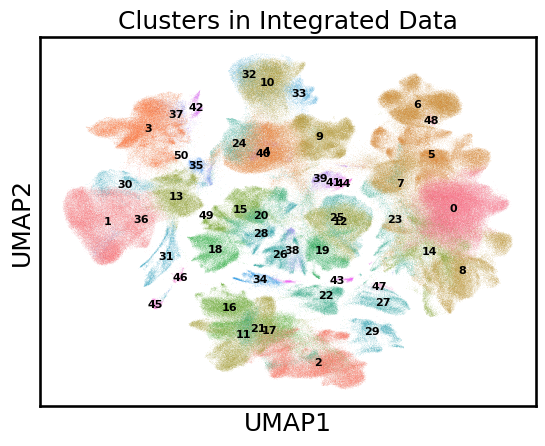

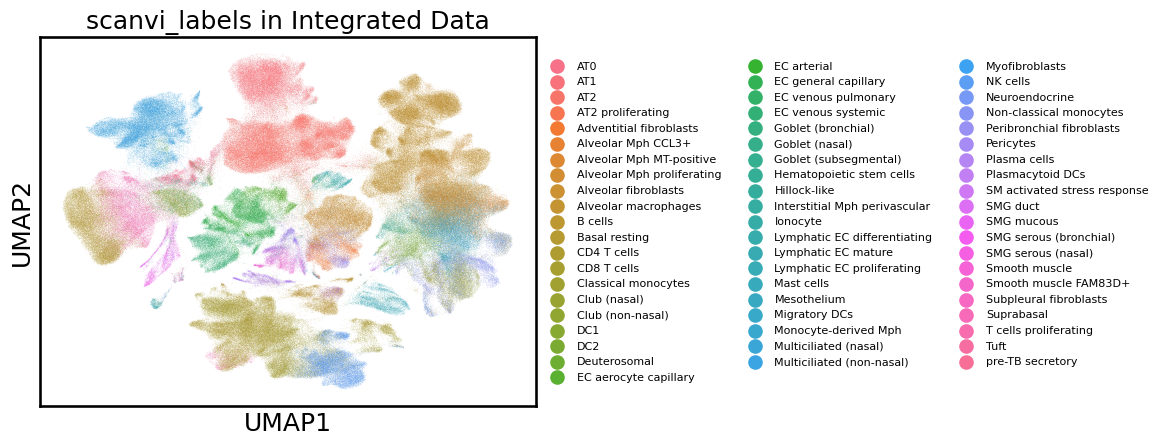

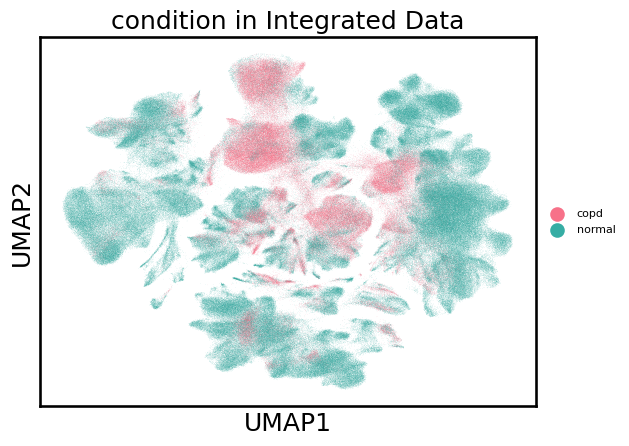

In [14]:
plot_clustering_with_colors(adata_scvi, label_key=label_key, condition_key=condition_key)

<Figure size 800x600 with 0 Axes>

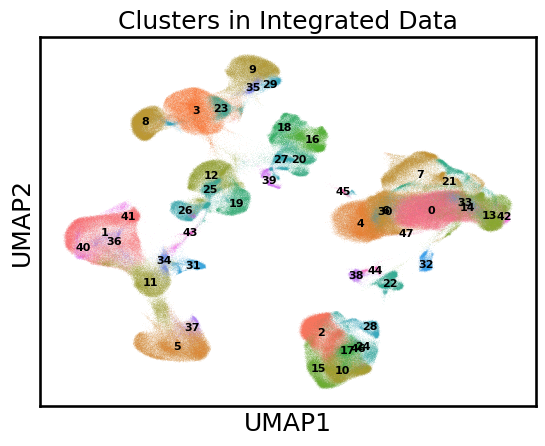

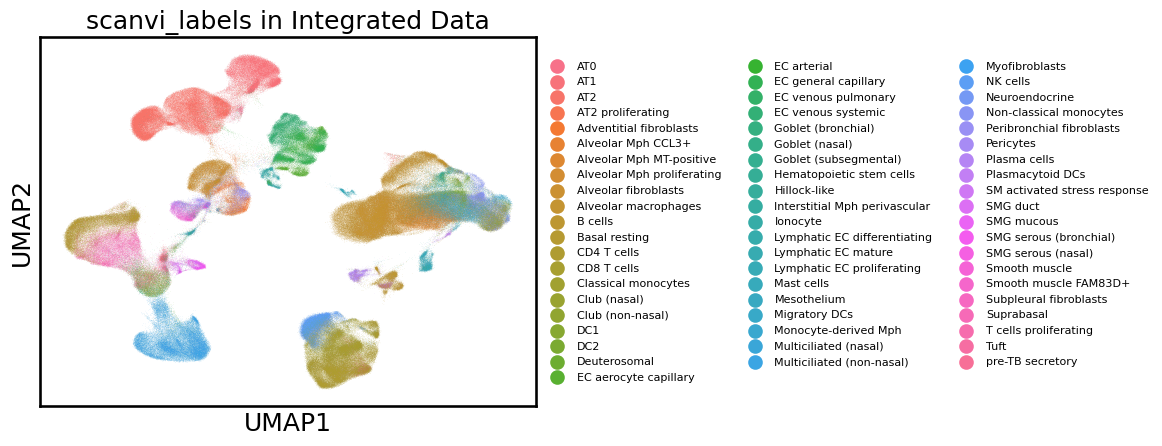

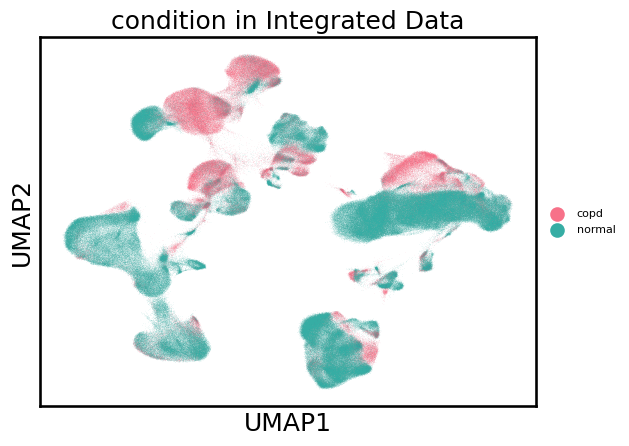

In [15]:
plot_clustering_with_colors(adata_bbknn, label_key=label_key, condition_key=condition_key)

### set the cluster key

In [16]:
#Add clustering labels to the anndata
adata_scvi.obs['cluster'] = adata_scvi.obs['leiden_res']
adata_bbknn.obs['cluster'] = adata_bbknn.obs['leiden_res']

# Calculate disease-specific gene signatures

### Prepare mapping 

- label_mapping: includes copd-specific gene signatures derived from 10 studies
- - manually harmonized cell type labels to level 2


In [17]:
label_mapping = pd.read_excel('./copd_genes/241126-copd signatures.xlsx', sheet_name='CombinedData') 
label_mapping

,study_number,baseline_comparison,condition,up_or_downregulated,gene,literature_celltype,harmonized_celltype(level2),harmonized_celltype_finest
0,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,CCL18,alveolar macrophages,Myeloid,Alveolar macrophages
1,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,C1QB,alveolar macrophages,Myeloid,Alveolar macrophages
2,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,APOC1,alveolar macrophages,Myeloid,Alveolar macrophages
3,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,IL1B,alveolar macrophages,Myeloid,Alveolar macrophages
4,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,HLA-DQB1,alveolar macrophages,Myeloid,Alveolar macrophages
...,...,...,...,...,...,...,...,...
11365,10,smoker controls wihtout chronic illness,CM NSCLC,upregulated,EEF1A1P5,CD+ EM,Lymphoid,CD4 T cells EM
11366,10,smoker controls wihtout chronic illness,CM NSCLC,upregulated,RPL27AP,CD+ EM,Lymphoid,CD4 T cells EM
11367,10,smoker controls wihtout chronic illness,CM NSCLC,upregulated,RPL41P5,CD+ EM,Lymphoid,CD4 T cells EM
11368,10,smoker controls wihtout chronic illness,CM NSCLC,upregulated,AC008481.1,CD+ EM,Lymphoid,CD4 T cells EM


We noticed some genes are gene ids, let's map gene ids to gene_symbols

In [18]:
path_ens_mapper = (
    "./supporting_files/Homo_sapiens_GRCh38_84_gene_ids_to_gene_symbol.csv"
)

In [19]:
gene_id_to_symbol_mapper = pd.read_csv(path_ens_mapper, index_col=0)
# turn into dict:
gene_id_to_symbol_mapper = dict(
    zip(gene_id_to_symbol_mapper.index, gene_id_to_symbol_mapper.gene_name)
)

In [20]:
# Step 1: Map genes to symbols using the mapping dictionary
label_mapping['gene_symbols'] = label_mapping['gene'].apply(
    lambda x: gene_id_to_symbol_mapper[x] if x in gene_id_to_symbol_mapper else x
)


In [21]:
label_mapping.head()

,study_number,baseline_comparison,condition,up_or_downregulated,gene,literature_celltype,harmonized_celltype(level2),harmonized_celltype_finest,gene_symbols
0,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,CCL18,alveolar macrophages,Myeloid,Alveolar macrophages,CCL18
1,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,C1QB,alveolar macrophages,Myeloid,Alveolar macrophages,C1QB
2,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,APOC1,alveolar macrophages,Myeloid,Alveolar macrophages,APOC1
3,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,IL1B,alveolar macrophages,Myeloid,Alveolar macrophages,IL1B
4,1,healthy smoker,"mild-to-moderate COPD (GOLD stage I, II)",upregulated,HLA-DQB1,alveolar macrophages,Myeloid,Alveolar macrophages,HLA-DQB1


In [22]:
unmapped_count = label_mapping['gene_symbols'].str.startswith('ENSG').sum()
unmapped_count

49

Check some of listed genes are unmapped, some of them are proteins, decide to remove them.

In [23]:
# Ensure 'gene_symbols' is treated as strings
label_mapping['gene_symbols'] = label_mapping['gene_symbols'].astype(str)

# Filter out rows where 'gene_symbols' starts with 'ENSG'
label_mapping = label_mapping[~label_mapping['gene_symbols'].str.startswith('ENSG', na=False)].reset_index(drop=True)

#### Load Cellxgene HLCA dataset, to get the annotations

In [24]:
# !wget -O ./data/hlca-v1.h5ad https://datasets.cellxgene.cziscience.com/cd9ac225-682a-4f39-b0de-29caeb532bec.h5ad


In [25]:
adata_hlca_1 = sc.read_h5ad('./data/hlca-v1.h5ad')

In [26]:
adata_hlca_1.obs.head()

,suspension_type,donor_id,is_primary_data,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,tissue_ontology_term_id,organism_ontology_term_id,sex_ontology_term_id,3'_or_5',BMI,age_or_mean_of_age_range,age_range,anatomical_region_ccf_score,ann_coarse_for_GWAS_and_modeling,ann_finest_level,ann_level_1,ann_level_2,ann_level_3,ann_level_4,ann_level_5,cause_of_death,core_or_extension,dataset,fresh_or_frozen,log10_total_counts,lung_condition,mixed_ancestry,original_ann_level_1,original_ann_level_2,original_ann_level_3,original_ann_level_4,original_ann_level_5,original_ann_nonharmonized,reannotation_type,sample,scanvi_label,sequencing_platform,smoking_status,study,subject_type,tissue_coarse_unharmonized,tissue_detailed_unharmonized,tissue_dissociation_protocol,tissue_level_2,tissue_level_3,tissue_sampling_method,total_counts,transf_ann_level_1_label,transf_ann_level_1_uncert,transf_ann_level_2_label,transf_ann_level_2_uncert,transf_ann_level_3_label,transf_ann_level_3_uncert,transf_ann_level_4_label,transf_ann_level_4_uncert,transf_ann_level_5_label,transf_ann_level_5_uncert,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
CGATGTAAGTTACGGG_SC10,cell,homosapiens_None_2023_None_sikkemalisa_002_d10...,True,EFO:0009899,CL:0000583,HsapDv:0000149,PATO:0000461,HANCESTRO:0008,UBERON:0008946,NCBITaxon:9606,PATO:0000384,3',NaN,55.0,nan,0.97,Alveolar macrophages,Alveolar macrophages,Immune,Myeloid,Macrophages,Alveolar macrophages,None,intracranial hemorrhage,core,Misharin_Budinger_2018,fresh,3.897132,Healthy,NaN,Immune,Myeloid,Macrophages,Alveolar macrophages,None,Alveolar macrophages,Correctly annotated,SC10,Macrophages,Illumina HiSeq 4000,former,Misharin_Budinger_2018,organ_donor,parenchyma,"side unknown, lower lobe",Collagenase D + DNAse,parenchyma lower lobe,NaN,donor_lung,7891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tissue,alveolar macrophage,10x 3' v2,normal,Homo sapiens,male,lung parenchyma,Asian,55-year-old stage,LL;0n*@mx8
cc05p_CATGCCTGTGTGCCTG_carraro_csmc,cell,homosapiens_None_2023_None_sikkemalisa_002_d10...,True,EFO:0009899,unknown,unknown,PATO:0000461,unknown,UBERON:0002048,NCBITaxon:9606,unknown,3',NaN,NaN,nan,NaN,NaN,Unknown,Epithelial,Airway epithelium,Basal,Unknown,Unknown,NaN,extension,Gomperts_2021_CSMC,NaN,3.069298,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,Basal,NaN,cc05p,NaN,NaN,NaN,Gomperts_2021,NaN,NaN,NaN,NaN,NaN,NaN,lung_explant,1173.0,Epithelial,5.960464e-08,Airway epithelium,5.960464e-08,Basal,5.960464e-08,Suprabasal,2.000024e-01,4_Suprabasal,2.000024e-01,tissue,unknown,10x 3' v2,normal,Homo sapiens,unknown,lung,unknown,unknown,)rNf~Q0&BX
ATTCTACCAAGGTTCT_HD68,cell,homosapiens_None_2023_None_sikkemalisa_002_d10...,True,EFO:0011025,CL:0002144,HsapDv:0000135,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,PATO:0000384,5',23.5,41.0,nan,0.97,EC capillary,EC aerocyte capillary,Endothelial,Blood vessels,EC capillary,EC aerocyte capillary,None,NaN,core,Banovich_Kropski_2020,fresh,3.257918,Healthy,NaN,Endothelial,Blood vessels,EC capillary,EC aerocyte capillary,None,Endothelial - CA4+ capillary,Correctly annotated,VUHD68,Capillary,Illumina NovaSeq 6000 S1,former,Banovich_Kropski_2020,organ_donor,parenchyma,right upper lobe,Dispase + collagenase,parenchyma upper lobe,parenchyma right upper lobe,donor_lung,1811.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tissue,capillary endothelial cell,10x 5' v1,normal,Homo sapiens,male,lung parenchyma,European,41-year-old stage,5%kv|ie@!5
D062_TGACCCTTCAAACCCA-sub_wang_sub_batch3,nucleus,homosapiens_None_2023_None_sikkemalisa_002_d10...,False,EFO:0009922,CL:4028004,HsapDv:0000262,PATO:0000461,unknown,UBERON:0002048,NCBITaxon:9606,PATO:0000384,3',NaN,0.0,nan,NaN,NaN,Alveolar fibroblasts,Stroma,Fibroblast lineage,Fibroblasts,Alveolar fibroblasts,NaN,NaN,extension,Sun_2020_batch3,NaN,3.385606,Healthy,NaN,Stroma,Fibroblast line

### Add level 2 label from the HLCA

Compare scanvi_labels of our datasets with HLCA labels (ann_level_3, ann_level_4, ann_level_5)

- worth to note here, scanvi_labels seems to be a combination of ann_level_3, ann_level_4, and ann_level_5

In [27]:
unique_scanvi_labels = set(adata_scvi.obs['scanvi_labels'].unique())
unique_ann_level_3 = set(adata_hlca_1.obs['ann_level_3'].unique())
unique_ann_level_4 = set(adata_hlca_1.obs['ann_level_4'].unique())
unique_ann_level_5 = set(adata_hlca_1.obs['ann_level_5'].unique())

Find labels in scanvi_labels that do not have a match in HLCA labels

In [28]:
missing_labels = unique_scanvi_labels - unique_ann_level_4 - unique_ann_level_5 - unique_ann_level_3
print("Labels in 'scanvi_labels' with no match in 'ann_level_4':", missing_labels)

Labels in 'scanvi_labels' with no match in 'ann_level_4': {'Hematopoietic stem cells', 'Smooth muscle', 'Mesothelium'}


In [29]:
# Step 1: Create a mapping dictionary using 'ann_level_4', 'ann_level_3', and 'ann_level_5' as keys
# and mapping them to 'ann_level_2'

mapping_dict = adata_hlca_1.obs[['ann_level_4', 'ann_level_3', 'ann_level_5', 'ann_level_2']].drop_duplicates()

# Reshape the DataFrame to create a dictionary mapping each level to 'ann_level_2'
#Because scanvi_labels seems to be a combination of ann_level_3, ann_level_4, and ann_level_5
mapping_dict = (
    mapping_dict.melt(id_vars=['ann_level_2'], 
                      value_vars=['ann_level_4', 'ann_level_3', 'ann_level_5'], 
                      value_name='key')
    .dropna(subset=['key'])  # Remove NaN keys
    .set_index('key')['ann_level_2']
    .to_dict()
)

Add 'ann_level_2' to our adata

In [30]:
# Step 2: Map 'scanvi_labels' in adata_scvi to 'ann_level_2' using the mapping dictionary
adata_scvi.obs['ann_level_2'] = adata_scvi.obs['scanvi_labels'].map(mapping_dict)

In [31]:
# Step 2: Map 'scanvi_labels' in adata_scvi to 'ann_level_2' using the mapping dictionary
adata_bbknn.obs['ann_level_2'] = adata_bbknn.obs['scanvi_labels'].map(mapping_dict)

In [32]:
adata_scvi.obs.head()

,sample_ID,donor_id,protocol_URL,institute,sample_collection_site,sample_collection_relative_time_point,library_ID,library_ID_repository,author_batch_notes,organism_ontology_term_id,manner_of_death,sample_source,sex_ontology_term_id,sample_collection_method,tissue_type,sampled_site_condition,tissue_ontology_term_id,tissue_free_text,sample_preservation_method,suspension_type,cell_enrichment,cell_viability_percentage,cell_number_loaded,sample_collection_year,assay_ontology_term_id,library_preparation_batch,library_sequencing_run,sequenced_fragment,sequencing_platform,is_primary_data,reference_genome,gene_annotation_version,alignment_software,intron_inclusion,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,development_stage_ontology_term_id,author_cell_type,cell_type_ontology_term_id,author_cell_type_markers,author_cell_type_description,celltypist_labels,scanvi_labels,scpoli_labels,n_counts,log1p_n_counts,n_genes,log1p_n_genes,percent_mito,n_counts_mito,percent_ribo,n_counts_ribo,percent_hb,n_counts_hb,percent_top50,cell_passed_qc,condition,study_name,_scvi_batch,_scvi_labels,leiden_res,cluster,ann_level_2
CGATGAAGTCGGTTTGACTTTAGG-21,A55-8,A55,https://www.10xgenomics.com/support/software/c...,Helmholtz Munich,DATAR_site_1,N/A,Library_Batch_5,N/A,Batch_5,NCBITaxon:9606,NaN,surgical donor,PATO:0000383,surgical resection,tissue,healthy,UBERON:0002174,,frozen at -80C,nucleus,CL:0000000,NaN,296800.0,2022.0,EFO:0008995,Batch_5,NA,probe-based,EFO:0008637,True,GRCh38,GCF_000001405.39,cellranger-7.1.0,yes,PATO:0000461,unknown,HsapDv:0000241,EC aerocyte capillary,CL:4028003,SOSTDC1;S100A3;EDNRB;EMCN;CYP3A5;PCDH12;HPGD;I...,NA,EC aerocyte capillary,EC aerocyte capillary,EC aerocyte capillary,1018,6.926577,635,6.548219,0.0,0.0,0.0,0.0,0.0,0.0,26.915521,True,normal,Yildirim_unpubl,4,0,20,20,Blood vessels
EEM-scRNA-079_AGAGAATCACTAGGTT,EEM-scRNA-079,UPENN0191,dx.doi.org/10.17504/protocols.io.b54gq8tw,University of Pennsylvania,University of Pennsylvania,,EEM-scRNA-079,N/A,N/A,NCBITaxon:9606,NaN,postmortem donor,PATO:0000384,surgical resection,tissue,healthy,UBERON:0008870,N/A,fresh,cell,CL:0000738-,85.0,8000.0,2021.0,EFO:0009922,N/A,N/A,3 prime tag,EFO:0008565,True,GRCh38,GENCODE v44/Ensembl110,STARsolo 2.7.9a_EmptyDrops_CR,no,PATO:0000461,unknown,HsapDv:0000239,AM,CL:0000583,NA,NA,Alveolar macrophages,Alveolar macrophages,Alveolar Mph CCL3+,12707,9.449987,2464,8.006368,0.0,0.0,0.0,0.0,0.0,0.0,33.398914,True,normal,lungMAP,8,0,5,5,Myeloid
TCACAAGGTGGCCCTA-1_CZINY-0652-3,D564_BAL,D564,doi:10.17504/protocols.io.bwrjpd4n,"Columbia University, New York, US",IA_site_2,N/A,"CZINY-0649,CZINY-0650,CZINY-0651,CZINY-0652,CZ...",Not public,N/A,NCBITaxon:9606,0.0,postmortem donor,PATO:0000384,brush,tissue,healthy,UBERON:0000065,Bronchoalveolar Lavage,fresh,cell,CL:0000842,90.0,NaN,2022.0,EFO:0009900,N/A,N/A,5 prime tag,N/A,True,GRCh38,N/A,cell ranger 6.0.0,yes,PATO:0000461,White,HsapDv:0000239,macrophage,CL:0000235,NA,NA,Monocyte-derived Mph,Alveolar Mph CCL3+,Alveolar Mph MT-positive,3011,8.010360,1138,7.269617,0.0,0.0,0.0,0.0,0.0,0.0,31.949518,True,normal,Jones_Yosef_Teichmann_Farber_Sims_unpubl,8,0,0,0,Myeloid
CATCGCTCAATGTCTG-1_GRO-14,S14,GRO-14,N/A,University Medical Center Groningen,UMCG_EXPIRE,S14_day1,N/A,N/A,Batch run by different personnel on different ...,NCBITaxon:9606,NaN,surgical donor,PATO:0000383,biopsy,tissue,healthy,"UBERON:0002171,UBERON:0008955",third and sixth generation of the right lower ...,fresh,cell,CL:0000000,80.0,3000.0,2020.0,EFO:0009922,batch14,Gron-4,3 prime tag,EFO_0008637,True,GRCh38,v98,cellranger-6.1.2,no,PATO:0000461,unknown,HsapDv:0000240,Suprabasal cells,CL:4033048,NA,NA,Unassigned,Basal resting,Basal resting,2827,7.947325,982,7.153052,0.0,0.0,0.0,0.0,0.0,0.0,41.032897,True,normal,Nawijn_unpubl,22,0,1,1,Airway epithelium
GGCGTGTAGCTGATAA-1_CTTV027_GRO-11,S11,GRO-11,N/A,University Medical Center Groningen,UMCG_EXPIRE,S11_day1,N/A,N/A,Batch run by different personnel on different ...,NCBITaxon:9606,NaN

# Wrap

### Summarize cell type labels and gene lists

Format label_mapping as: {harmonized_celltype(level2): genes}

- {'AT1': ['GDF15', 'S100A4', 'FTL', 'SELM', 'FOLR1', 'XPC'], }

In [33]:
gene_signatures = (
    label_mapping.groupby('harmonized_celltype(level2)')['gene_symbols']
    .apply(list)
    .to_dict()
)
print(gene_signatures)

{'Airway epithelium': ['FGA', 'RPRML', 'CYP1B1', 'SAA1', 'SAA1', 'KRT23', 'DHRS9', 'TMEM154', 'BASP1', 'TFPI', 'MGST1', 'RPL22L1', 'FTL', 'FTL', 'RPL36', 'GABARAP', 'RPS10', 'TMSB4X', 'GTF2IRD2', 'FARP1', 'S100A10', 'S100A10', 'FOLR1', 'C19orf33', 'CAV1', 'CRIP1', 'SLITRK6', 'SLITRK6', 'TACC2', 'FKBP5', 'ZBTB16', 'STAT3', 'CPEB4', 'NUPR1', 'AGR3', 'FABP6', 'CSNK1A1', 'STPG2', '45544', 'BRD2', 'CCDC200', 'HIST1H2BD', 'RPL13AP5', 'SGK1', 'PDK4', 'RPLP0', 'DPY30', 'RUNX1', 'CRY2', 'TRIM2', 'MTSS1', 'VPS37B', 'UQCRB', 'ETS2', 'MGST1', 'EPCAM', 'DDX3X', 'PPP1CB', 'EXOC4', 'CTNNB1', 'UBE2H', 'CYTH1', 'MT-CYB', 'GOLGA2P10', 'HSPA1A', 'NEDD4L', 'CPLANE1', 'WFDC2', 'SMG1P3', 'GRM5', 'NFIA', 'RNASEK', 'WWC1', 'NDUFA1', 'TCF7L2', 'SCHLAP1', 'FTL', 'RPS19', 'HSPA8', 'COX6A1', 'TNFRSF10B', 'COX7C', 'COX7B', 'CD63', 'TACC2', 'RPS2', 'CRIM1', 'DBI', 'DGKI', 'CSTB', 'RPL15', 'MUC16', 'CAMK1D', 'CD55', 'UBL5', 'RPL13AP7', 'COX6A1P2', 'RP11-295K3.1', 'CTD-2060L22.1', 'FNBP1', 'DCAF6', 'SCGB1A1', 'SCGB3A

### Overview of gene signatures

In [34]:
gene_count_per_cell_type = {cell_type: len(set(genes)) for cell_type, genes in gene_signatures.items()}
print(gene_count_per_cell_type)

{'Airway epithelium': 787, 'Alveolar epithelium': 303, 'Blood vessels': 377, 'Fibroblast lineage': 282, 'Low quality': 22, 'Lymphatic EC': 232, 'Lymphoid': 808, 'Myeloid': 3019, 'Secretory': 92, 'Smooth muscle': 58}


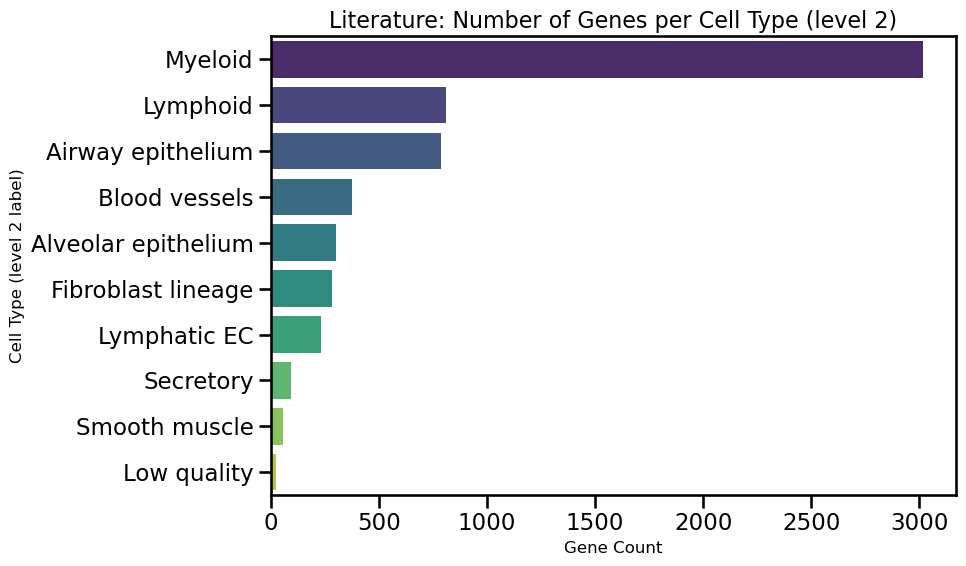

In [35]:
gene_count_df = pd.DataFrame(list(gene_count_per_cell_type.items()), columns=['Cell_type', 'Gene_count'])

# Sort the data by Gene_count for better visualization
gene_count_df = gene_count_df.sort_values(by='Gene_count', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Gene_count', y='Cell_type', data=gene_count_df, palette='viridis')

# Add labels and title
plt.title('Literature: Number of Genes per Cell Type (level 2)', fontsize=16)
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Cell Type (level 2 label)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### per-cell type score

To check the mapping between label_mapping['harmonized_celltype(level2)'] and adata_scvi['ann_level_2']

In [36]:
# # Step 1: Extract unique values from both columns
# label_mapping_celltypes = set(label_mapping['harmonized_celltype(level2)'].unique())
# adata_scvi_celltypes = set(adata_scvi.obs['ann_level_2'].unique())

# # Step 2: Check overlap and differences
# common_celltypes = label_mapping_celltypes & adata_scvi_celltypes  # Intersection
# missing_in_label_mapping = adata_scvi_celltypes - label_mapping_celltypes  # In adata_scvi but not in label_mapping
# missing_in_adata_scvi = label_mapping_celltypes - adata_scvi_celltypes  # In label_mapping but not in adata_scvi

# # Step 3: Output the results
# print(f"Common cell types: {common_celltypes}")
# print(f"Cell types in adata_scvi but not in label_mapping: {missing_in_label_mapping}")
# print(f"Cell types in label_mapping but not in adata_scvi: {missing_in_adata_scvi}")


## COPD-associated gene signatures (take max score per cluster only)

Compute gene signature score for each cell type

- loop through each cell type in 'gene signatures'
- 

In [38]:
adata = adata_scvi
for cell_type, genes in gene_signatures.items():
    matched_genes = [gene for gene in genes if gene in adata.var['gene_symbols'].values]
    print(cell_type)
    print(len(matched_genes))

Airway epithelium
252
Alveolar epithelium
97
Blood vessels
147
Fibroblast lineage
102
Low quality
8
Lymphatic EC
71
Lymphoid
373
Myeloid
1108
Secretory
23
Smooth muscle
13


In [50]:
# def compute_average_expression(adata, gene_signatures, label_key):
#     """
#     Compute average gene expression scores for each cell type based on gene signatures.

#     Parameters:
#     - adata: AnnData object containing gene expression data.
#     - gene_signatures: Dictionary where keys are cell types and values are lists of gene symbols.
#     - label_key: Key in adata.obs that indicates the cell type labels.

#     Returns:
#     - DataFrame with cell types and their corresponding average gene expression scores.
#     """
#     # Initialize a dictionary to store the average gene expression scores
#     average_expression_scores = {}

#     # Loop through each cell type in gene signatures
#     for cell_type, genes in gene_signatures.items():
#         # Find matching genes in adata.var
#         matched_genes = [gene for gene in genes if gene in adata.var['gene_symbols'].values]
        
#         if matched_genes:
#             # Get Ensembl IDs for matched genes
#             matched_ensembl_ids = adata.var[adata.var['gene_symbols'].isin(matched_genes)].index
            
#             # Select cells of the current cell type
#             cells_of_type = adata[adata.obs[label_key] == cell_type]

#             if cells_of_type.n_obs > 0:
#                 # Get indices of matched Ensembl IDs in adata.var
#                 gene_indices = adata.var.index.get_indexer(matched_ensembl_ids)

#                 # Filter out any -1 indices (which indicate unmatched genes)
#                 valid_gene_indices = gene_indices[gene_indices != -1]

#                 # Ensure we have valid indices to use for gene expression retrieval
#                 if valid_gene_indices.size > 0:
#                     # Get the gene expression matrix for the matched genes
#                     gene_expression = cells_of_type.X[:, valid_gene_indices]
                    
#                     # Calculate the mean gene expression for matched genes
#                     average_expression = gene_expression.mean(axis=1)  # Mean across genes for each cell
#                     average_expression_scores[cell_type] = average_expression.mean()  # Average across all cells of this type
#                 else:
#                     average_expression_scores[cell_type] = np.nan
#             else:
#                 average_expression_scores[cell_type] = np.nan
#         else:
#             average_expression_scores[cell_type] = np.nan

#     # Create a new DataFrame to store results
#     expression_scores_df = pd.DataFrame(list(average_expression_scores.items()), columns=['Cell_type', 'Average_gene_expression'])

#     return expression_scores_df


In [56]:
def compute_average_expression_with_score_genes(adata, gene_signatures, label_key):
    """
    Compute average gene expression scores for each cell type using scanpy.tl.score_genes.

    Parameters:
    - adata: AnnData object containing gene expression data.
    - gene_signatures: Dictionary where keys are cell types and values are lists of gene symbols.
    - label_key: Key in adata.obs that indicates the cell type labels.

    Returns:
    - DataFrame with cell types and their corresponding average gene expression scores.
    """
    # Ensure 'gene_symbols' exists in adata.var
    if 'gene_symbols' not in adata.var.columns:
        raise ValueError("'gene_symbols' column is missing in adata.var.")

    # Initialize a dictionary to store the average gene expression scores
    average_expression_scores = {}

    # Loop through each cell type in gene signatures
    for cell_type, gene_list in gene_signatures.items():
        # Map gene symbols to Ensembl IDs
        valid_genes = adata.var_names[adata.var['gene_symbols'].isin(gene_list)]

        if len(valid_genes) == 0:
            print(f"No valid genes found for cell type '{cell_type}'. Skipping.")
            average_expression_scores[cell_type] = np.nan
            continue

        # Filter cells of the current cell type
        cells_of_type = adata[adata.obs[label_key] == cell_type]

        if cells_of_type.n_obs > 0:
            # Use scanpy's score_genes function to compute the score for the valid gene list
            try:
                sc.tl.score_genes(cells_of_type, gene_list=valid_genes, ctrl_size=50, 
                                  score_name=f'{cell_type}_score')
                
                # Average the scores across all cells of the cell type
                average_score = cells_of_type.obs[f'{cell_type}_score'].mean()
                average_expression_scores[cell_type] = average_score
            except Exception as e:
                # Handle any errors in the scoring process
                print(f"Error calculating score for cell type '{cell_type}': {e}")
                average_expression_scores[cell_type] = np.nan
        else:
            average_expression_scores[cell_type] = np.nan

    # Create a new DataFrame to store results
    expression_scores_df = pd.DataFrame(list(average_expression_scores.items()), 
                                        columns=['Cell_type', 'Average_gene_expression'])

    return expression_scores_df


In [57]:
compute_average_expression_with_score_genes(adata=adata_scvi, gene_signatures=gene_signatures, label_key='ann_level_2')

,Cell_type,Average_gene_expression
0,Airway epithelium,0.287319
1,Alveolar epithelium,0.376911
2,Blood vessels,0.319392
3,Fibroblast lineage,0.256777
4,Low quality,NaN
5,Lymphatic EC,0.338001
6,Lymphoid,0.264631
7,Myeloid,0.360767
8,Secretory,NaN
9,Smooth muscle,0.234206


In [58]:
compute_average_expression_with_score_genes(adata=adata_bbknn, gene_signatures=gene_signatures, label_key='ann_level_2')

,Cell_type,Average_gene_expression
0,Airway epithelium,0.287319
1,Alveolar epithelium,0.376911
2,Blood vessels,0.319392
3,Fibroblast lineage,0.256777
4,Low quality,NaN
5,Lymphatic EC,0.338001
6,Lymphoid,0.264631
7,Myeloid,0.360767
8,Secretory,NaN
9,Smooth muscle,0.234206


## Cluster-wise score

In [92]:
def average_copd_expression_per_cluster(adata, gene_signatures, cluster_key='cluster'):
    """
    Calculate average gene expression scores per cluster in an AnnData object,
    along with the number of genes in the gene signature.

    Parameters:
    - adata: AnnData object containing gene expression data.
    - gene_signatures: Dictionary where keys are cell types and values are lists of gene symbols.
    - cluster_key: Column name in adata.obs representing clusters (default is 'cluster').

    Returns:
    - expression_scores_df: DataFrame with average gene expression scores per cluster
                            and the number of genes in the gene signature.
    """
    # Ensure 'gene_symbols' exists in adata.var
    if 'gene_symbols' not in adata.var.columns:
        raise ValueError("'gene_symbols' column is missing in adata.var.")

    # Initialize dictionaries to store results
    average_expression_scores_per_cluster = {}
    cluster_to_gene_count = {}

    # Loop through each unique cluster
    for cluster in adata.obs[cluster_key].unique():
        # Select cells belonging to the current cluster
        cells_in_cluster = adata[adata.obs[cluster_key] == cluster]

        # Initialize variables to track average expression and gene count
        max_mean_expression = -np.inf
        gene_count = 0

        # Loop through each cell type in gene signatures
        for cell_type, gene_list in gene_signatures.items():
            # Map gene symbols to Ensembl IDs
            matched_genes = adata.var_names[adata.var['gene_symbols'].isin(gene_list)]

            if len(matched_genes) > 0:
                # Use scanpy's score_genes to compute the score
                try:
                    sc.tl.score_genes(cells_in_cluster, gene_list=matched_genes, ctrl_size=50, 
                                      score_name=f'{cell_type}_score')
                    # Calculate mean score for the current cell type
                    cell_type_mean_expression = cells_in_cluster.obs[f'{cell_type}_score'].mean()

                    # Update max mean expression and gene count
                    if cell_type_mean_expression > max_mean_expression:
                        max_mean_expression = cell_type_mean_expression
                        gene_count = len(set(matched_genes))
                except Exception as e:
                    print(f"Error calculating score for cell type '{cell_type}' in cluster '{cluster}': {e}")

        # Assign results to dictionaries
        average_expression_scores_per_cluster[cluster] = max_mean_expression if max_mean_expression > -np.inf else np.nan
        cluster_to_gene_count[cluster] = gene_count

    # Create a DataFrame to store results
    expression_scores_df = pd.DataFrame({
        'Cluster': list(average_expression_scores_per_cluster.keys()),
        'Cell type': list(cell_type),
        'Mean_gene_expression': list(average_expression_scores_per_cluster.values()),
        'Gene_count': list(cluster_to_gene_count.values())
    })

    return expression_scores_df

In [94]:
def average_copd_expression_per_cluster(adata, gene_signatures, cluster_key='cluster'):
    """
    Calculate average and maximum gene expression scores per cluster in an AnnData object,
    including the cell type and the number of genes in the gene signature.

    Parameters:
    - adata: AnnData object containing gene expression data.
    - gene_signatures: Dictionary where keys are cell types and values are lists of gene symbols.
    - cluster_key: Column name in adata.obs representing clusters (default is 'cluster').

    Returns:
    - expression_scores_df: DataFrame with average and maximum gene expression scores per cluster,
                            the best-matching cell type, and the number of genes in the gene signature.
    """
    # Ensure 'gene_symbols' exists in adata.var
    if 'gene_symbols' not in adata.var.columns:
        raise ValueError("'gene_symbols' column is missing in adata.var.")

    # Initialize dictionaries to store results
    average_expression_scores_per_cluster = {}
    max_expression_scores_per_cluster = {}
    cluster_to_cell_type = {}
    cluster_to_gene_count = {}

    # Loop through each unique cluster
    for cluster in adata.obs[cluster_key].unique():
        # Select cells belonging to the current cluster
        cells_in_cluster = adata[adata.obs[cluster_key] == cluster]

        # Initialize variables to track the best-matching cell type
        best_cell_type = None
        max_mean_expression = -np.inf
        gene_count = 0

        # Loop through each cell type in gene signatures
        for cell_type, gene_list in gene_signatures.items():
            # Map gene symbols to Ensembl IDs
            matched_genes = adata.var_names[adata.var['gene_symbols'].isin(gene_list)]

            if len(matched_genes) > 0:
                # Use scanpy's score_genes to compute the score
                try:
                    sc.tl.score_genes(cells_in_cluster, gene_list=matched_genes, ctrl_size=50, 
                                      score_name=f'{cell_type}_score')
                    # Calculate mean score for the current cell type
                    cell_type_mean_expression = cells_in_cluster.obs[f'{cell_type}_score'].mean()

                    # Update the best-matching cell type if the current one has a higher mean score
                    if cell_type_mean_expression > max_mean_expression:
                        best_cell_type = cell_type
                        max_mean_expression = cell_type_mean_expression
                        gene_count = len(matched_genes)
                except Exception as e:
                    print(f"Error calculating score for cell type '{cell_type}' in cluster '{cluster}': {e}")

        # Assign results to dictionaries
        average_expression_scores_per_cluster[cluster] = max_mean_expression if best_cell_type else np.nan
        max_expression_scores_per_cluster[cluster] = max_mean_expression  # Same as average in this context
        cluster_to_cell_type[cluster] = best_cell_type
        cluster_to_gene_count[cluster] = gene_count

    # Create a DataFrame to store results
    expression_scores_df = pd.DataFrame({
        'Cluster': list(average_expression_scores_per_cluster.keys()),
        'Mean_gene_expression': list(average_expression_scores_per_cluster.values()),
        'Best_matching_cell_type': list(cluster_to_cell_type.values()),
        'Gene_count': list(cluster_to_gene_count.values())
    })

    return expression_scores_df

In [95]:
expression_scores_scvi = average_copd_expression_per_cluster(adata_scvi, gene_signatures)
expression_scores_bbknn = average_copd_expression_per_cluster(adata_bbknn, gene_signatures)

In [96]:
expression_scores_scvi

,Cluster,Mean_gene_expression,Best_matching_cell_type,Gene_count
0,20,0.345869,Blood vessels,104
1,5,0.405120,Myeloid,444
2,0,0.367086,Myeloid,444
3,1,0.296101,Airway epithelium,208
4,27,0.200743,Myeloid,444
5,11,0.299434,Lymphoid,153
6,7,0.359833,Myeloid,444
7,6,0.370586,Myeloid,444
8,17,0.209505,Lymphoid,153
9,30,0.388670,Airway epithelium,208


In [97]:
expression_scores_bbknn

,Cluster,Mean_gene_expression,Best_matching_cell_type,Gene_count
0,20,0.346094,Blood vessels,104
1,6,0.407090,Myeloid,444
2,0,0.362366,Myeloid,444
3,1,0.299388,Airway epithelium,208
4,32,0.205460,Myeloid,444
5,10,0.324644,Lymphoid,153
6,7,0.357881,Myeloid,444
7,4,0.371021,Myeloid,444
8,15,0.213317,Lymphoid,153
9,11,0.330836,Airway epithelium,208


### COPD_score plot

In [109]:
def plot_mean_gene_expression_per_cluster(expression_scores_df, figsize=(10, 6), palette='viridis'):
    """
    Create a bar plot of mean gene expression scores per cluster.

    Parameters:
    - expression_scores_df: DataFrame containing 'cluster' and 'overall_mean_gene_expression' columns.
    - figsize: Tuple specifying the size of the figure (default is (10, 6)).
    - palette: Color palette to use for the bars (default is 'viridis').

    Returns:
    - None: Displays the plot.
    """
    # Set up the plot size and style
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    # Create a bar plot of mean gene expression scores per cluster
    sns.barplot(data=expression_scores_df, x='Cluster', y='Mean_gene_expression', palette=palette)

    # Add titles and labels
    plt.title('Mean Gene Expression Scores per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Overall Mean Gene Expression')

    # Display the plot
    plt.xticks(rotation=45)  # Rotate cluster labels for better readability, if needed
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

# Example usage:
# plot_mean_gene_expression_per_cluster(expression_scores_df)


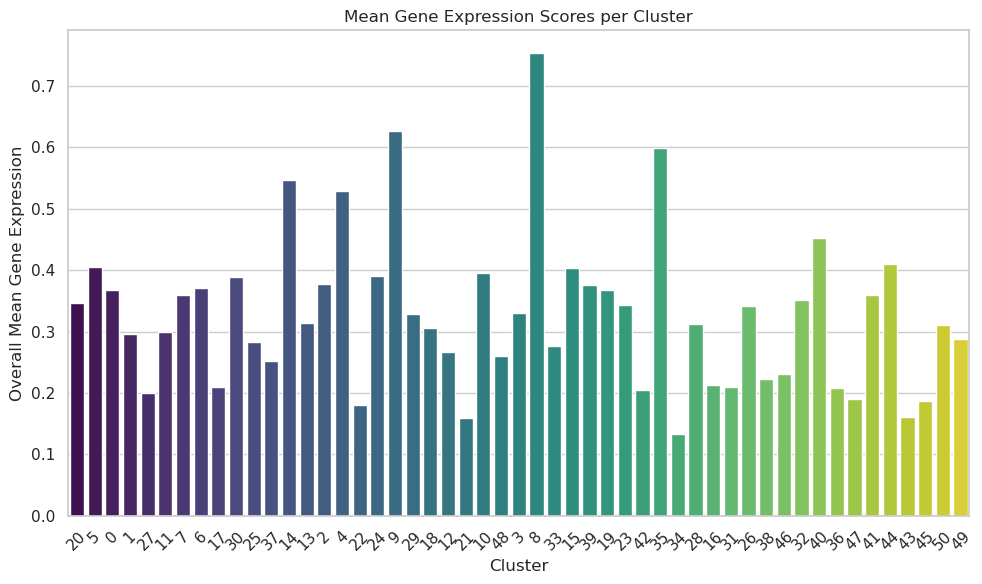

In [110]:
plot_mean_gene_expression_per_cluster(expression_scores_scvi, figsize=(10, 6), palette='viridis')

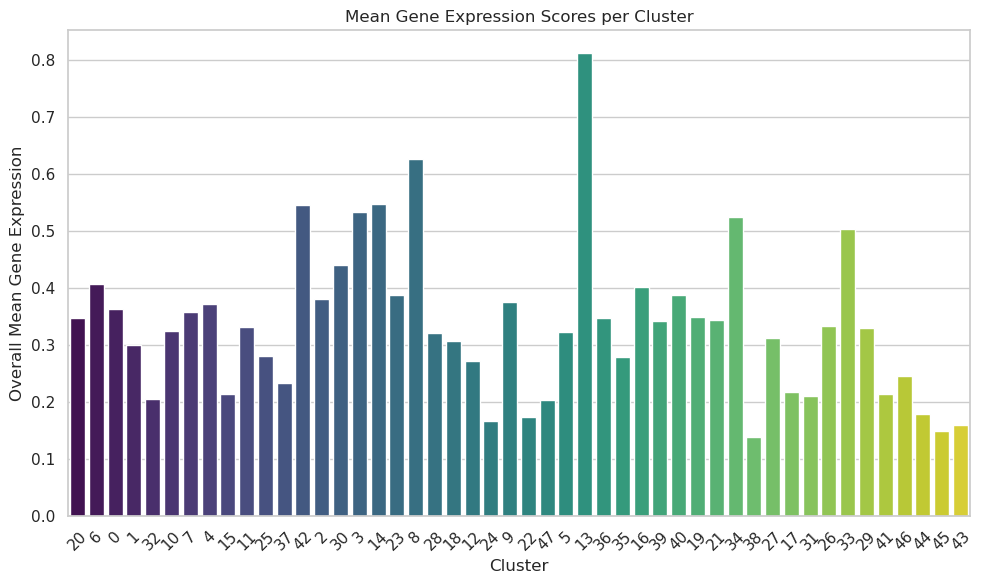

In [111]:
plot_mean_gene_expression_per_cluster(expression_scores_bbknn, figsize=(10, 6), palette='viridis')

## Correlation between COPD-gene expression score and number of COPD genes

In [103]:
correlation, p_value = stats.pearsonr(expression_scores_scvi['Mean_gene_expression'], expression_scores_scvi['Gene_count'])
print(f"Correlation between Max_gene_expression and Gene_count: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")

Correlation between Max_gene_expression and Gene_count: -0.217
P-value: 1.259e-01


In [104]:
correlation, p_value = stats.pearsonr(expression_scores_bbknn['Mean_gene_expression'], expression_scores_bbknn['Gene_count'])
print(f"Correlation between Max_gene_expression and Gene_count: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")

Correlation between Max_gene_expression and Gene_count: -0.268
P-value: 6.581e-02


In [81]:


def plot_correlation_with_regression(data, x_col, y_col, label_col, title=None, x_label=None, y_label=None, figsize=(8, 6)):
    """
    Plots a scatter plot with a regression line and annotates it with the Pearson correlation coefficient, 
    p-value, and adds cell type labels on each data point.
    
    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: Column name for the x-axis values.
    - y_col: Column name for the y-axis values.
    - label_col: Column name containing the cell type labels to annotate each point.
    - title: Title of the plot (default: None).
    - x_label: Label for the x-axis (default: None, uses x_col).
    - y_label: Label for the y-axis (default: None, uses y_col).
    - figsize: Tuple specifying the figure size (default: (8, 6)).
    
    Returns:
    - correlation: Pearson correlation coefficient.
    - p_value: p-value for the correlation.
    """
    # Calculate Pearson correlation
    correlation, p_value = stats.pearsonr(data[x_col], data[y_col])

    # Set up the plot style
    sns.set(style="whitegrid")

    # Create the scatter plot with regression line
    plt.figure(figsize=figsize)
    sns.regplot(
        data=data,
        x=x_col,
        y=y_col,
        scatter_kws={'s': 100, 'alpha': 0.7},  # Size and transparency of scatter points
        line_kws={'color': 'red'},  # Regression line color
    )

    # Add plot details
    plt.title(title if title else f'Correlation between {x_col} and {y_col}')
    plt.xlabel(x_label if x_label else x_col)
    plt.ylabel(y_label if y_label else y_col)
    plt.grid(True, linestyle='--', alpha=0.6)

        # Annotate the correlation score on the plot (top-left corner)
    plt.text(
        x=0.05 * plt.gca().get_xlim()[0],  # Position close to the left
        y=0.95 * plt.gca().get_ylim()[1],  # Position close to the top
        s=f"r = {correlation:.3f}\nP = {p_value:.3e}",
        fontsize=12,
        color="blue",
        bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.5")
    )


    # Collect text annotations for the labels
    texts = []
    for i, row in data.iterrows():
        text = plt.text(
            x=row[x_col], 
            y=row[y_col], 
            s=row[label_col],
            fontsize=10,
            color='black',
            ha='right', 
            va='bottom', 
            alpha=0.7
        )
        texts.append(text)

    # Adjust label positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return correlation, p_value
